### Step 0: Setup and Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

2025-10-03 14:34:12.727072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759502053.094070      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759502053.199882      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Step 1: Load & Preprocess Data (CIFAR10)

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize [0,1]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Flatten targets
y_train = y_train.flatten()
y_test = y_test.flatten()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


### Step 2: Define Data Augmentation

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(.1),
    tf.keras.layers.RandomZoom(.1),
    tf.keras.layers.RandomContrast(.1)
], name='data_augmentation')

#### Step 2b. Define the Model (Functional API)

In [10]:
def build_cnn(input_shape=(32,32,3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    # Apply augmentation first
    x = data_augmentation(inputs)

    # Normal CNN flow layer1
    x = tf.keras.layers.Conv2D(32, (3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    # Flatten then Dense
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(.5)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name='cnn_with_aug')
    return model

### Step 3: Compile Model

In [11]:
model = build_cnn()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Step 4: Train and Evaluate model

In [14]:
def train_and_evaluate(model,x_train, y_train, x_test, y_test, epochs=10):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=128, validation_split=.1, verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Accuracy:{test_acc:.4f}")
    return history, test_acc

### Step 5: Run Experiments

In [17]:
model_history, model_acc = train_and_evaluate(model, x_train, y_train, x_test, y_test,20)

Epoch 1/20
352/352 - 5s - 13ms/step - accuracy: 0.6500 - loss: 1.0153 - val_accuracy: 0.6904 - val_loss: 0.8953
Epoch 2/20
352/352 - 4s - 12ms/step - accuracy: 0.6499 - loss: 1.0113 - val_accuracy: 0.6442 - val_loss: 1.0871
Epoch 3/20
352/352 - 4s - 12ms/step - accuracy: 0.6544 - loss: 1.0003 - val_accuracy: 0.6736 - val_loss: 0.9578
Epoch 4/20
352/352 - 4s - 12ms/step - accuracy: 0.6606 - loss: 0.9865 - val_accuracy: 0.6756 - val_loss: 0.9490
Epoch 5/20
352/352 - 4s - 12ms/step - accuracy: 0.6619 - loss: 0.9821 - val_accuracy: 0.6804 - val_loss: 0.9250
Epoch 6/20
352/352 - 4s - 12ms/step - accuracy: 0.6635 - loss: 0.9705 - val_accuracy: 0.6956 - val_loss: 0.9072
Epoch 7/20
352/352 - 4s - 12ms/step - accuracy: 0.6677 - loss: 0.9592 - val_accuracy: 0.6802 - val_loss: 0.9369
Epoch 8/20
352/352 - 4s - 12ms/step - accuracy: 0.6718 - loss: 0.9511 - val_accuracy: 0.6800 - val_loss: 0.9481
Epoch 9/20
352/352 - 4s - 12ms/step - accuracy: 0.6719 - loss: 0.9412 - val_accuracy: 0.7246 - val_loss:

# Step 6: Visualizations 

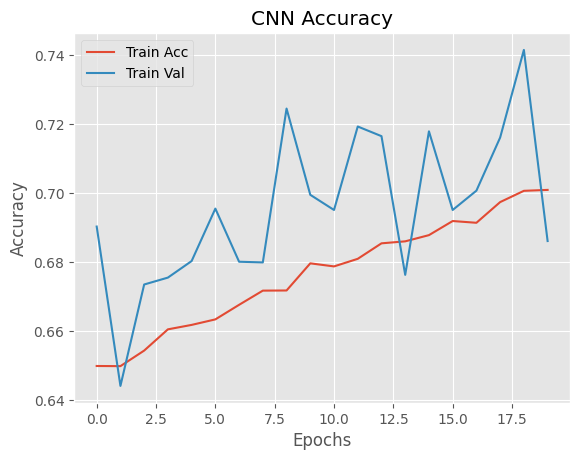

In [19]:
plt.plot(model_history.history['accuracy'], label='Train Acc')
plt.plot(model_history.history['val_accuracy'], label='Train Val')
plt.xlabel('Epochs');plt.ylabel('Accuracy');plt.title('CNN Accuracy')
plt.legend()
plt.show()

### Step 7: Notes 
* Padding="same" -> keeps feature maps from shrinking too fast
* BatchNorm -> Stabilizers activations, reduces internal covariate shift, allows higher learning rates